In [64]:
#Dependencies
import requests as req
import json
# pip install citipy
from citipy import citipy # downloaded from https://pypi.python.org/pypi/citipy
# https://github.com/wingchen/citipy for how to use it and more info about it

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [65]:
# coordinates: (latitude (horizontal), longitude (vertical))
    #coordinate range: ([-90,90], [-180, 180])
city = citipy.nearest_city(-100, 90).city_name
country = citipy.nearest_city(-100, 90).country_code

# Testing to see if coordinates work 
test = [[city, country]]
test[0]

['albany', 'au']

In [66]:
# url, api key for openweathermap (OWM)
url = ' http://api.openweathermap.org/data/2.5/weather' #For how to use OWM's api: https://openweathermap.org/current
apiKey = 'c8e2baf63c2571f94bf9d95c94483400' # my requested api key

payload_Test = {'APPID':apiKey, 'units':'imperial', 'q': str(test[0][0]) + ',' + str(test[0][1])} # q doesn't seem to be case sensitive


testResp = req.get(url, params=payload_Test)
weather = testResp.json()

# Testing to see if OpenWeatherMap can find test city and country
weather

{'base': 'stations',
 'clouds': {'all': 32},
 'cod': 200,
 'coord': {'lat': -35.02, 'lon': 117.89},
 'dt': 1512794878,
 'id': 2077963,
 'main': {'grnd_level': 1012.55,
  'humidity': 25,
  'pressure': 1012.55,
  'sea_level': 1025.12,
  'temp': 92.59,
  'temp_max': 92.59,
  'temp_min': 92.59},
 'name': 'Albany',
 'sys': {'country': 'AU',
  'message': 0.246,
  'sunrise': 1512766048,
  'sunset': 1512818062},
 'weather': [{'description': 'scattered clouds',
   'icon': '03d',
   'id': 802,
   'main': 'Clouds'}],
 'wind': {'deg': 10.0007, 'speed': 10.65}}

In [123]:
# Sample of 500 countries from citipy

#loop to fill the sample list with 600 entries
def getCitySample(number):
    sample_ls = []
    city_ls = []
    country_ls = []

    while len(sample_ls) < number:
        Lati = np.random.uniform(low = -90, high = 90)
        Longi = np.random.uniform(low = -180, high = 180)

        #get nearest city name and country code (in case city name is common one)
        city = citipy.nearest_city(Lati, Longi).city_name
        country = citipy.nearest_city(Lati, Longi).country_code

        #check if city name is in the sample list
        duplicate = False
        for entry in sample_ls:
            if city == entry[0] and country == entry [1]:
                duplicate = True
                break
            else:
                continue
        if duplicate == False:
            city_ls.append(city)
            country_ls.append(country)
            sample_ls.append([city, country])

            
    #dataframe of the sample of cities
    columns=['Country', 'Date', 'TimeStamp', 'Cloudiness', 'Humidity', 'Latitude', 'Longitude', 'Max Temp', 'Wind Speed (mph)']
    df = pd.DataFrame(data=sample_ls, index=city_ls)
    df = df.reindex(columns=columns) #set blank columns
    df['Country'] = country_ls # add in country abbreviations

    return df

# get sample of cities == 10
citySample_df = getCitySample(10)

citySample_df
    

,Country,Date,TimeStamp,Cloudiness,Humidity,Latitude,Longitude,Max Temp,Wind Speed (mph)
atuona,pf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zaysan,kz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pierre,us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yellowknife,ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vaini,to,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
albany,au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ponta do sol,cv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
illoqqortoormiut,gl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quesnel,ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nylstroom,za,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# url, api key for openweathermap (OWM)
url = ' http://api.openweathermap.org/data/2.5/weather' #For how to use OWM's api: https://openweathermap.org/current
apiKey = 'c8e2baf63c2571f94bf9d95c94483400' # my requested api key

# loop through dataframe to get values for each index
def getWeather(df):
    count = 0
    drop_count = 0 # count the number of dropped values 
    for index, row in df.iterrows():
        #print log of each city as it's being processed. 
        print('Processing Record Number ' + str(count+1) + ' | ' + index)
    
        #get weather data based on city and country
        payload_sampl = {'APPID':apiKey, 'units':'imperial', 'q': index + ',' + row['Country']} 
            # q doesn't seem to be case sensitive
        weather = req.get(url, params=payload_sampl)
        weather_json = weather.json()
        try:     
            if weather_json['cod'] == 200: #'cod' seems to equal '404' if city isn't found in OWM. 'cod' == 200 otherwise. 
                df.set_value(index, 'TimeStamp', weather_json['dt'])
                df.set_value(index, 'Latitude', weather_json['coord']['lat'])
                df.set_value(index, 'Longitude', weather_json['coord']['lon'])
                df.set_value(index, 'Max Temp', weather_json['main']['temp_max'])
                df.set_value(index, 'Humidity', weather_json['main']['humidity'])
                df.set_value(index, 'Cloudiness', weather_json['clouds']['all']) #measure of cloudiness?
                df.set_value(index, 'Wind Speed (mph)', weather_json['wind']['speed'])
                print(weather.url)
            if weather_json['cod'] == '404':
                df.drop(index, inplace=True)
                drop_count += 1
                print('City Not Found! Dropping the Row in the DataFrame! | ' +  'Row(s) dropped: '+ str(drop_count))
                print(weather.url)
        except ValueError:
            df.drop(index, inplace=True)
            print('There was a ValueError!')
            continue
        
        count += 1
    print('\n' + str(len(df)) + ' total rows.')
    print('\n' + str(drop_count) + ' row(s) have been dropped due to absence in the OWM api.')
    
    return(df)

#get weather for citySample_df
citySample_df = getWeather(citySample_df)
citySample_df

Processing Record Number 1 | atuona
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=atuona%2Cpf
Processing Record Number 2 | zaysan
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=zaysan%2Ckz
Processing Record Number 3 | pierre
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=pierre%2Cus
Processing Record Number 4 | yellowknife
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=yellowknife%2Cca
Processing Record Number 5 | vaini
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=vaini%2Cto
Processing Record Number 6 | albany
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=albany%2Cau
Processing Record Number 7 | ponta do sol
http://api.openweathermap.org/data/2.5/weath

,Country,Date,TimeStamp,Cloudiness,Humidity,Latitude,Longitude,Max Temp,Wind Speed (mph)
atuona,pf,NaN,1.512800e+09,68.0,100.0,-9.80,-139.03,79.54,16.62
zaysan,kz,NaN,1.512801e+09,12.0,75.0,47.47,84.87,25.50,5.06
pierre,us,NaN,1.512799e+09,1.0,69.0,44.37,-100.35,37.40,19.46
yellowknife,ca,NaN,1.512799e+09,90.0,85.0,62.46,-114.35,10.40,9.17
vaini,to,NaN,1.512799e+09,40.0,94.0,-21.20,-175.20,75.20,20.60
albany,au,NaN,1.512800e+09,32.0,25.0,-35.02,117.89,92.59,10.65
ponta do sol,cv,NaN,1.512800e+09,76.0,100.0,17.20,-25.09,75.94,16.13
quesnel,ca,NaN,1.512799e+09,1.0,79.0,53.00,-122.50,28.40,11.41


In [125]:
# adding to df if length of citySample_df < 500
def addCities(number, df):
    while len(df) < number:
        addCities_df = getCitySample(number-len(df))
        addCities_df = getWeather(addCities_df)
    
        # append addCities_df to citySample_df
        df = df.append(addCities_df)
        print ('\n' + 'Total rows in dataframe: ' + str(len(df)) + '\n')
    return df

# add cities to citySample_df
citySample_df = addCities(50, citySample_df)
citySample_df

Processing Record Number 1 | bluff
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=bluff%2Cnz
Processing Record Number 2 | qaqortoq
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=qaqortoq%2Cgl
Processing Record Number 3 | albany
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=albany%2Cau
Processing Record Number 4 | maluso
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=maluso%2Cph
Processing Record Number 5 | te anau
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=te+anau%2Cnz
Processing Record Number 6 | kalianget
http://api.openweathermap.org/data/2.5/weather?APPID=c8e2baf63c2571f94bf9d95c94483400&units=imperial&q=kalianget%2Cid
Processing Record Number 7 | bogale
http://api.openweathermap.org/data/2.5/weather?A

2 total rows.

0 row(s) have been dropped due to absence in the OWM api.
Total rows in dataframe: 50


,Country,Date,TimeStamp,Cloudiness,Humidity,Latitude,Longitude,Max Temp,Wind Speed (mph)
atuona,pf,NaN,1.512800e+09,68.0,100.0,-9.80,-139.03,79.54,16.62
zaysan,kz,NaN,1.512801e+09,12.0,75.0,47.47,84.87,25.50,5.06
pierre,us,NaN,1.512799e+09,1.0,69.0,44.37,-100.35,37.40,19.46
yellowknife,ca,NaN,1.512799e+09,90.0,85.0,62.46,-114.35,10.40,9.17
vaini,to,NaN,1.512799e+09,40.0,94.0,-21.20,-175.20,75.20,20.60
albany,au,NaN,1.512800e+09,32.0,25.0,-35.02,117.89,92.59,10.65
ponta do sol,cv,NaN,1.512800e+09,76.0,100.0,17.20,-25.09,75.94,16.13
quesnel,ca,NaN,1.512799e+09,1.0,79.0,53.00,-122.50,28.40,11.41
bluff,nz,NaN,1.512800e+09,48.0,99.0,-46.60,168.33,61.41,17.40
qaqortoq,gl,NaN,1.512799e+09,92.0,38.0,60.72,-46.03,42.80,49.44


In [126]:
# Formatting citySample dataframe
    #drop cases where row is all NaN just in case
citySample_df['Max Temp'].dropna(axis=0, inplace=True)

        #format date from unix timestamp 
citySample_df['TimeStamp'] = pd.to_datetime(citySample_df['TimeStamp'], unit='s')

citySample_df['Date'] = [d.date() for d in citySample_df['TimeStamp']]

#save to csv in same folder as code
citySample_df.to_csv('citySample_dataframe.csv')

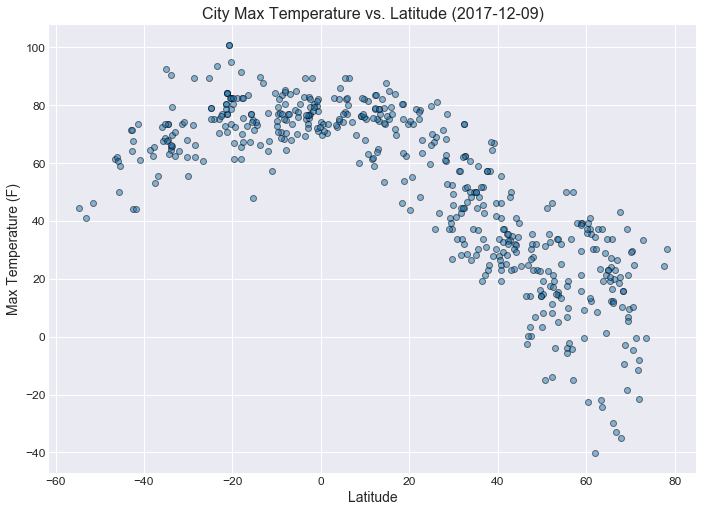

In [70]:
#Scatterplot of Temperature (F) vs. Latitude
sns.set_style('dark')

# Set figuresize, grid, and plot scatterplot
fig, ax = plt.subplots(figsize=(11.6, 8.25))
ax.grid(linestyle='-', linewidth=1)
plt.scatter(x=citySample_df['Latitude'], y=citySample_df['Max Temp'], edgecolor='black', alpha=0.5)

#Set titles and font sizes
plt.title('City Max Temperature vs. Latitude' + ' (' + str(citySample_df['Date'].iloc[0]) + ')', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Max Temperature (F)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#save as png file
fig.savefig('City Max Temperature vs. Latitude.png')

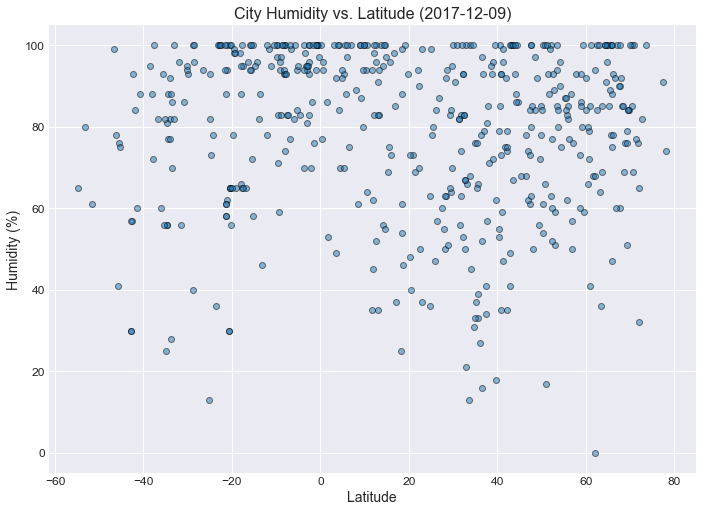

In [71]:
# Scatterplot of Humidity (%) vs. Latitude

sns.set_style('dark')

# Set figuresize, grid, and plot scatterplot
fig, ax = plt.subplots(figsize=(11.6, 8.25))
ax.grid(linestyle='-', linewidth=1)
plt.scatter(x=citySample_df['Latitude'], y=citySample_df['Humidity'], edgecolor='black', alpha=0.5)

#Set titles and font sizes
plt.title('City Humidity vs. Latitude' + ' (' + str(citySample_df['Date'].iloc[0]) + ')', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Humidity (%)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#save as png file
fig.savefig('City Humidity vs. Latitude.png')

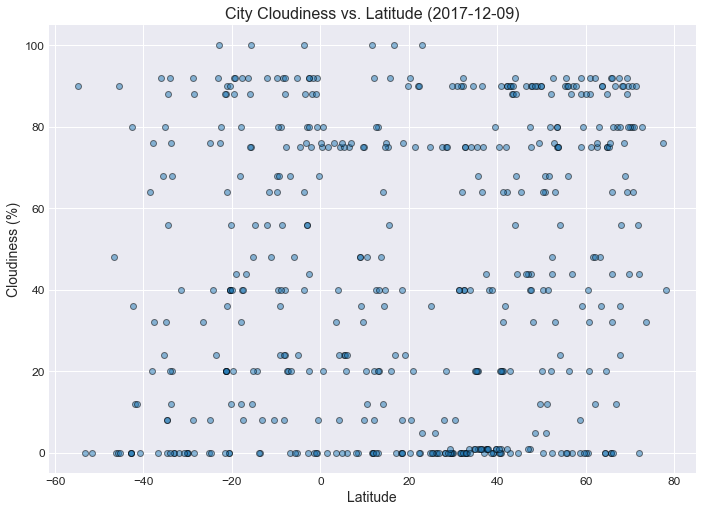

In [72]:
#Scatterplot of Cloudiness (%) vs. Latitude

sns.set_style('dark')

# Set figuresize, grid, and plot scatterplot
fig, ax = plt.subplots(figsize=(11.6, 8.25))
ax.grid(linestyle='-', linewidth=1)
plt.scatter(x=citySample_df['Latitude'], y=citySample_df['Cloudiness'], edgecolor='black', alpha=0.5)

#Set titles
plt.title('City Cloudiness vs. Latitude' + ' (' + str(citySample_df['Date'].iloc[0]) + ')', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Cloudiness (%)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#save as png file
fig.savefig('City Cloudiness vs. Latitude.png')

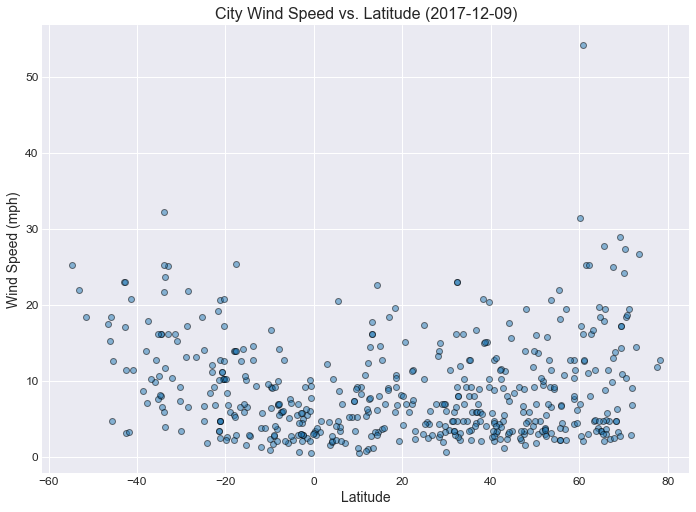

In [73]:
# Scatterplot of Wind Speed (mph) vs. Latitude

sns.set_style('dark')

# Set figuresize, grid, and plot scatterplot
fig, ax = plt.subplots(figsize=(11.6, 8.25))
ax.grid(linestyle='-', linewidth=1)
plt.scatter(x=citySample_df['Latitude'], y=citySample_df['Wind Speed (mph)'], edgecolor='black', alpha=0.5)

# Set titles
plt.title('City Wind Speed vs. Latitude' + ' (' + str(citySample_df['Date'].iloc[0]) + ')', fontsize = 16)
plt.xlabel('Latitude', fontsize = 14)
plt.ylabel('Wind Speed (mph)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#save as png file
fig.savefig('City Wind Speed vs. Latitude.png')